# Data Smoothing

In this chapter, we'll learn various methods for smoothing the data, which is an important step to take before attempting to build a predictive model.

## Smoothing the data

The daily reported data has a tremendous amount of variation due to many factors (weekdays vs weekends, holidays, and other reporting delays). Our goal when modeling is to understand the **general trend** of the data and not the variations due to reporting. Let's instantiate our `PrepareData` class and use it to read in the dictionary of all four DataFrames.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dashboard.mplstyle')

from prepare import PrepareData
data = PrepareData(download_new=False).run()

### Smoothing Texas's data

To show how smoothing works, we'll examine the cases in Texas. Let's get an overall view of cumulative cases with a line plot.

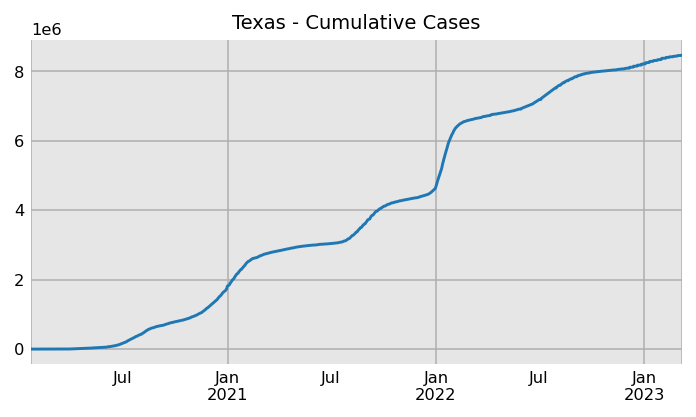

In [2]:
usa_cases = data['usa_cases']
texasc = usa_cases['Texas']
texasc.plot(kind='line', title="Texas - Cumulative Cases");

Except for a few small bumps, the graph looks fairly smooth. Let's investigate further and use the `diff` method to find the daily cases. By default, `diff` returns the difference between the current and previous values.

In [3]:
texasc_daily = texasc.diff()
texasc_daily.head()

2020-01-22    NaN
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
Name: Texas, dtype: float64

The first value will always be missing when finding the 1-day difference as there is no data from the previous day. Also, there were no cases for the first several weeks of recorded data in Texas. Let's find the last date where no cases were recorded.

In [4]:
last_zero_date = texasc[texasc == 0].index[-1]
last_zero_date

Timestamp('2020-03-04 00:00:00')

We filter the data from to show this date onwards.

In [5]:
texasc = texasc.loc[last_zero_date:]
texasc.head()

2020-03-04     0
2020-03-05     3
2020-03-06     4
2020-03-07     8
2020-03-08    11
Name: Texas, dtype: int64

Now when we use the `diff` method, we can simply drop the first missing value to get only the days from when the first case was recorded.

In [6]:
texasc_daily = texasc.diff().dropna().astype('int')
texasc_daily.head()

2020-03-05    3
2020-03-06    1
2020-03-07    4
2020-03-08    3
2020-03-09    2
Name: Texas, dtype: int32

Plotting the daily cases shows quite a large amount of variation.

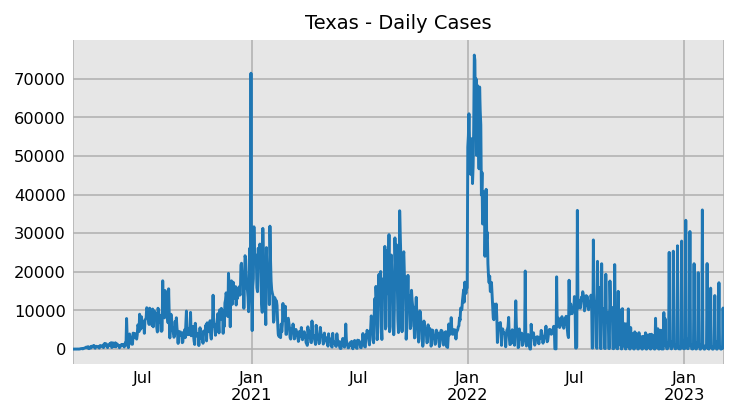

In [7]:
texasc_daily.plot(kind='line', title="Texas - Daily Cases");

## Smoothing methods

A [wide variety of data smoothing methods exist][1], three of which we'll cover in detail.

* Moving average
* Weighted smoothing
* Locally weighted scatterplot smoothing (LOWESS)

[1]: https://en.wikipedia.org/wiki/Smoothing

## Moving average

A simple moving average takes a window of points around each point and calculates the average of those points as the new value for that date. The starting and ending window is chosen by the user. 

### Weekly seasonality

The above graph of daily cases appears like what you would see monitoring a heart beat. There are spikes and dips at regular intervals. The cycles might appear on a weekly basis. **Seasonality** is a term that describes a regular repeating pattern in time series data. Let's get the average cases by day name to see if we can show that weekly seasonality occurs. All days should be roughly equal if there is no seasonality.

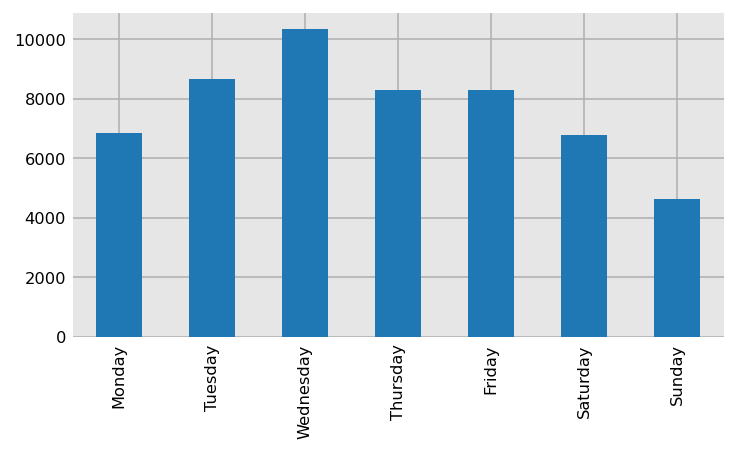

In [8]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
texasc_daily.groupby(lambda x: x.day_name()).mean().loc[days].plot(kind='bar');

As expected, a significant difference in the average between days exists. To account for this weekly seasonality, we will calculate a 7-day moving average. In, pandas, the moving average is calculated with the `rolling` method. Setting `center` to `True` chooses the three days preceding/following the current point and average them together. Here, we plot the smoothed and original data.

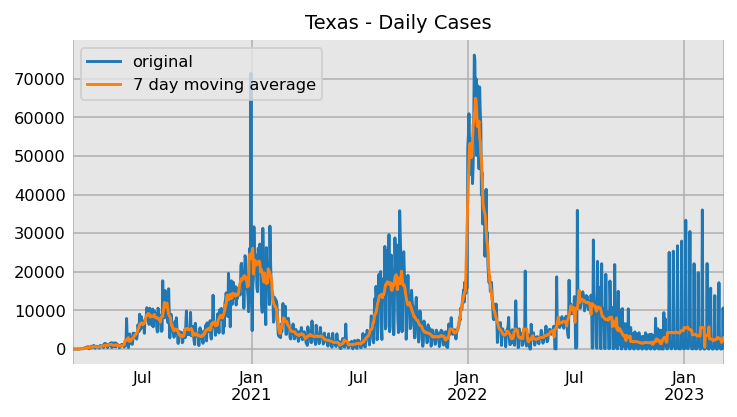

In [9]:
ma = texasc_daily.rolling(7, min_periods=1, center=True).mean()
texasc_daily.plot(kind='line', title="Texas - Daily Cases", label='original')
ma.plot(kind='line', label='7 day moving average').legend();

There is substantially less variation, but still not a smooth line like we could draw by hand.

### Repeated moving average

We can take the moving average repeatedly to smooth the data further. Here, we complete three iterations of the 7-day moving average and produce an even smoother plot.

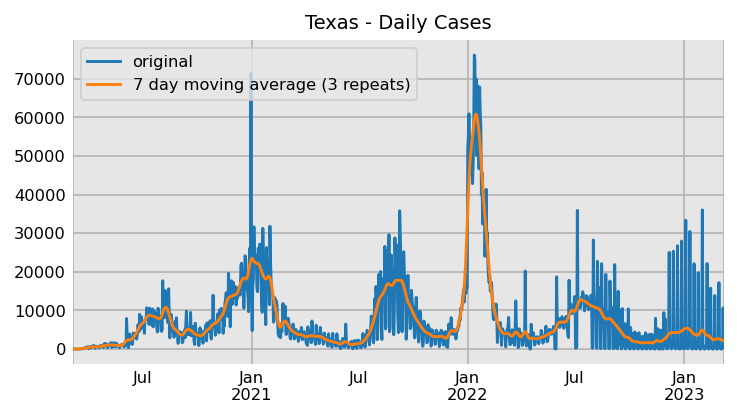

In [10]:
ma = texasc_daily
for _ in range(3):
    ma = ma.rolling(7, min_periods=1, center=True).mean()

texasc_daily.plot(title="Texas - Daily Cases", label='original')
ma.plot(label='7 day moving average (3 repeats)').legend();

We write a loop to plot differing number of repeats of the 7-day moving average.

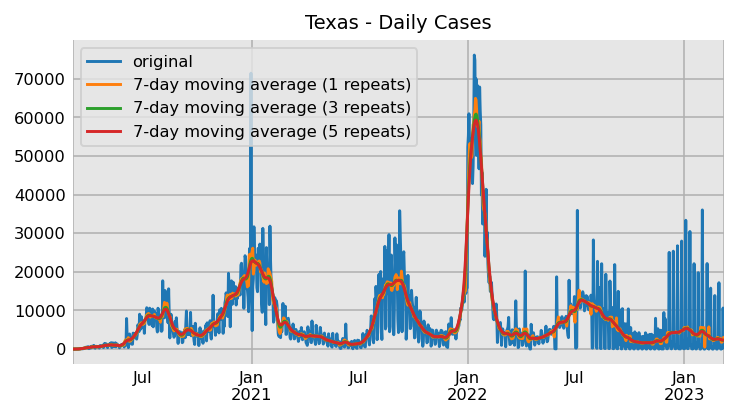

In [11]:
texasc_daily.plot(title="Texas - Daily Cases", label='original')
repeats_to_plot = [0, 2, 4]
ma = texasc_daily
for i in range(5):
    ma = ma.rolling(7, min_periods=1, center=True).mean()
    if i in repeats_to_plot:
        ma.plot(label=f'7-day moving average ({i + 1} repeats)').legend();

### Get the smoothed cumulative total

We can take the cumulative sum of the smoothed daily cases to get a smoothed cumulative total. Here, we repeat the smoothing process three times, take its cumulative sum, and plot it against the original.

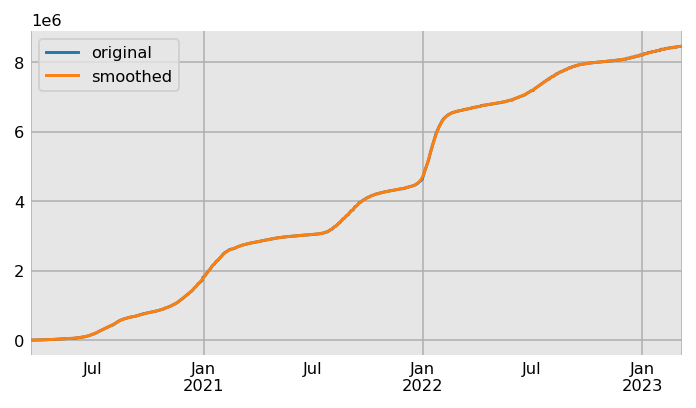

In [12]:
ma = texasc_daily
for i in range(3):
    ma = ma.rolling(7, min_periods=1, center=True).mean()

texasc_smoothed = ma.cumsum()
texasc.loc['2020-03-20':].plot(kind='line', label='original');
texasc_smoothed.loc['2020-03-20':].plot(label='smoothed').legend();

## Weighted smoothing

A slightly different technique involves taking a weighted average of the surround points with the points closer to the actual point given more weight. Here, we use a 7-day window and give 30% of the weight to the current observation, 15% each to the two nearest points, 12% each to the next two points, and 8% to the outer two points. This weighted moving average is plotted with the original moving average, so you can see the difference. In pandas, we had to create a custom function with `apply` to calculate the weighted sum.

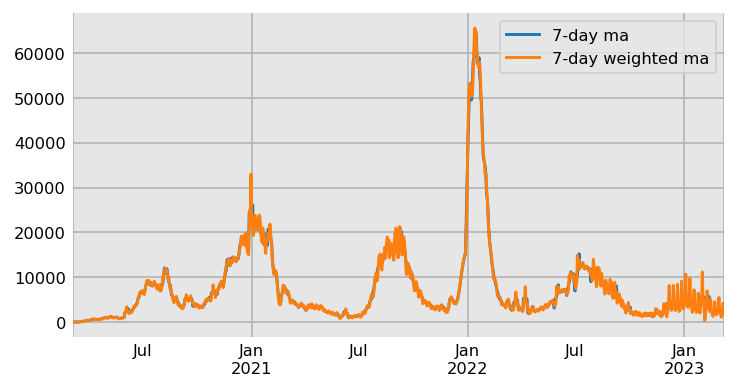

In [13]:
weight = np.array([.08, .12, .15, .30, .15, .12, .08])
def weighted_sum(x):
    w = weight[:len(x)]
    return (w * x).sum() / w.sum()
    
ma = texasc_daily.rolling(7, min_periods=1, center=True).mean()
maw = texasc_daily.rolling(7, min_periods=1, center=True).apply(weighted_sum)
ma.plot(label='7-day ma')
maw.plot(label='7-day weighted ma').legend();

### Exponentially weighted smoothing

Instead of setting all the weights ourselves, we can use a function that exponentially decreases the weights with respect to their distance from the current point. 

$$w_i = \alpha (1 - \alpha) ^ i $$

The above function calculates the weight at each point where $i$ represents the ith previous observation beginning at 0 from the current observation. The parameter $\alpha$ determines the rate at which to discount previous observations. Higher values of $\alpha$ place more importance on the closest observations.

In pandas, we use the `ewm` method, passing it in the value of alpha. Let's output the first 10 observations and then calculate the exponentially weighted mean with pandas.

In [14]:
texasc_daily.head(10)

2020-03-05     3
2020-03-06     1
2020-03-07     4
2020-03-08     3
2020-03-09     2
2020-03-10     3
2020-03-11     5
2020-03-12     6
2020-03-13    17
2020-03-14    16
Name: Texas, dtype: int32

In [15]:
texasc_daily.ewm(alpha=.7).mean().head(10).round(0)

2020-03-05     3.0
2020-03-06     1.0
2020-03-07     3.0
2020-03-08     3.0
2020-03-09     2.0
2020-03-10     3.0
2020-03-11     4.0
2020-03-12     6.0
2020-03-13    14.0
2020-03-14    15.0
Name: Texas, dtype: float64

### Verify by calculating manually

Let's calculate the exponentially weighted average of the last observation by hand to help understand exponential smoothing better. First, we calculate the weights using the formula above. The weight array is reversed to align with the Series which has the last observation at the end.

In [16]:
a = .7
w = a * (1 - a) ** np.arange(10)
w = w[::-1]
w

array([1.37781e-05, 4.59270e-05, 1.53090e-04, 5.10300e-04, 1.70100e-03,
       5.67000e-03, 1.89000e-02, 6.30000e-02, 2.10000e-01, 7.00000e-01])

We can now take the weighted average to replicate the last result from pandas `ewm`.

In [17]:
(texasc_daily.head(10) * w).sum() / w.sum()

15.26523266097234

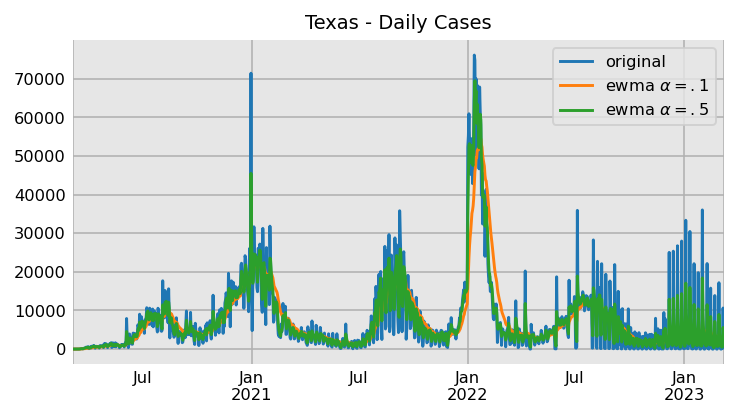

In [18]:
texasc_daily.plot(title="Texas - Daily Cases", label='original')
texasc_daily.ewm(alpha=.1).mean().plot(kind='line', label=r'ewma $\alpha=.1$')
texasc_daily.ewm(alpha=.5).mean().plot(kind='line', label=r'ewma $\alpha=.5$').legend();

One issue with the `ewm` method is that it does not allow you to center the calculation and use points on both sides of the current point. In order to do this, we'll reverse the Series, use `ewm` from the right side and then average the results together.

In [19]:
left = texasc_daily.ewm(alpha=.1).mean()
right = texasc_daily[::-1].ewm(alpha=.1).mean()

Let's output the estimates for each to show the difference.

In [20]:
left.tail()

2023-03-05    2521.703223
2023-03-06    2305.432900
2023-03-07    2131.589610
2023-03-08    2981.830649
2023-03-09    2713.147584
Name: Texas, dtype: float64

In [21]:
right.head()

2023-03-09     295.000000
2023-03-08    5736.578947
2023-03-07    3828.985240
2023-03-06    2819.975284
2023-03-05    2131.353447
Name: Texas, dtype: float64

Thanks to pandas automatic alignment of the index, we can add the two Series together knowing that the dates will align properly.

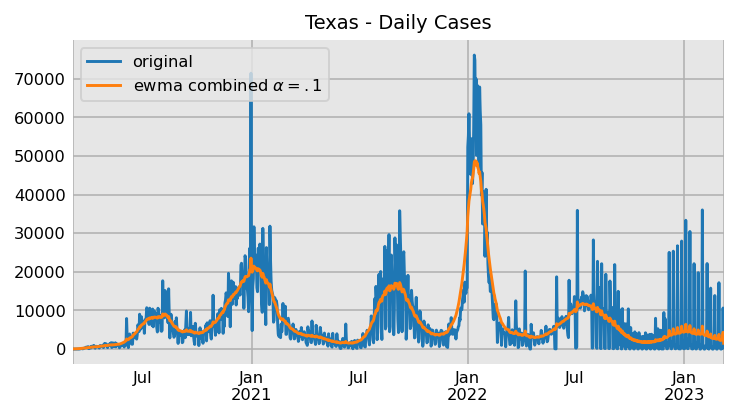

In [22]:
ewm_both = (left + right) / 2
texasc_daily.plot(title="Texas - Daily Cases", label='original')
ewm_both.plot(kind='line', label=r'ewma combined $\alpha=.1$').legend();

We can repeat the procedure multiple times like we did above to generate much smoother data. This repetition allows us to use a higher alpha.

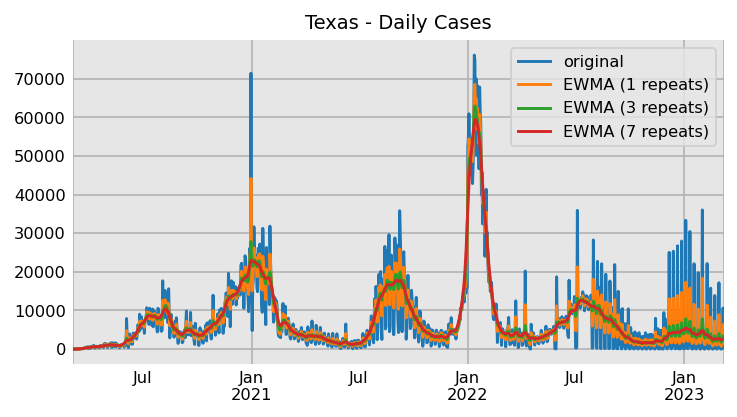

In [23]:
texasc_daily.plot(title="Texas - Daily Cases", label='original')
n = [0, 2, 6]
ewma = texasc_daily
for i in range(30):
    left = ewma.ewm(alpha=.5).mean()
    right = ewma[::-1].ewm(alpha=.5).mean()
    ewma = (left + right) / 2
    if i in n:
        ewma.plot(label=f'EWMA ({i + 1} repeats)').legend();

## LOWESS

Locally weighted scatterplot smoothing, or LOWESS, is a procedure that also places more weight on the nearest observations. It fits a low-degree polynomial regression line through these weighted points. LOWESS is a computationally expensive procedure and not available directly in pandas. Below, we import the `lowess` function from the [statsmodels package][1].

The main parameter is `frac` which is a number between 0 and 1 and determines the window size to consider as a fraction of the data. To be consistent as time goes on (and the length of our series increases), we'll choose a constant number of data points and use it to calculate `frac`. Here, we smooth based on 15 points. The last 10 smoothed points are shown below as a numpy array.

[1]: https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html#statsmodels.nonparametric.smoothers_lowess.lowess

In [24]:
from statsmodels.nonparametric.smoothers_lowess import lowess
y = texasc_daily
x = y.index
frac = 20 / len(x)
y_lowess = lowess(y, x, frac=frac, is_sorted=True, return_sorted=False)
y_lowess[-10:].round()

array([474., 446., 420., 394., 367., 340., 312., 285., 259., 234.])

Let's make a Series out of this array and then plot it.

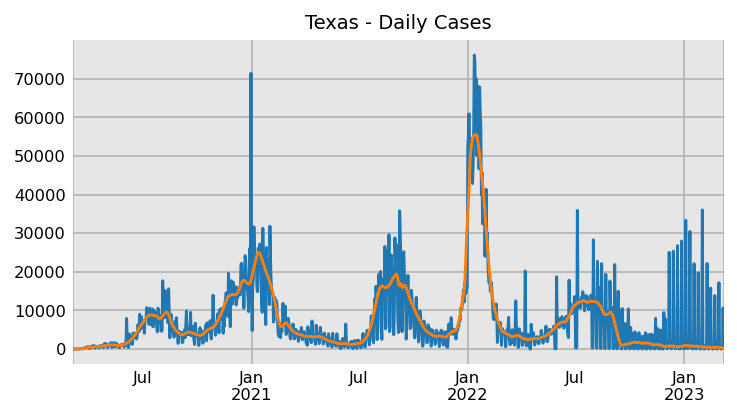

In [25]:
s_lowess = pd.Series(data=y_lowess, index=x)
texasc_daily.plot(title="Texas - Daily Cases", label='original')
s_lowess.plot();

### Smoothed cumulative total

Let's compute the smoothed cumulative total from the smoothed daily values.

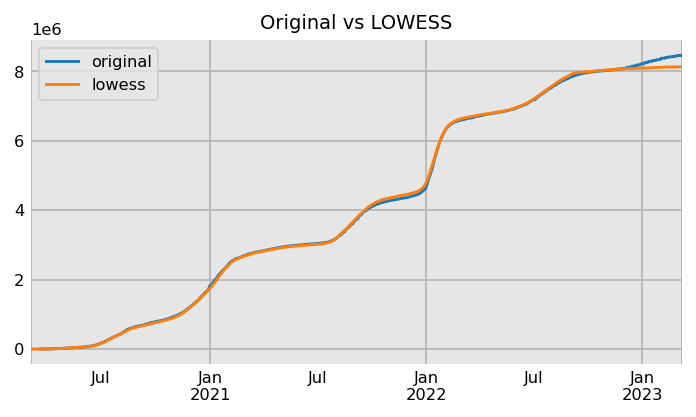

In [26]:
texasc.loc['2020-03-20':].plot(kind='line', label='original');
s_lowess_cumulative = s_lowess.cumsum().round(0).astype('int')
ax = s_lowess_cumulative.plot(label='lowess', title='Original vs LOWESS')
ax.legend();

### Aligning the cumulative total to the actual

Smoothing the daily values has the effect of the cumulative total not being in direct alignment with the original data. Take a look at the last values from the actual and smoothed series.

In [27]:
# actual
last_actual = texasc.values[-1]
last_actual

8466220

In [28]:
# smoothed
last_smoothed = s_lowess_cumulative.values[-1]
last_smoothed

8131324

To align the two series, we'll multiply the smoothed values by the ratio of their last values. The new last smoothed cumulative value is output to verify it is equal to the last actual value.

In [29]:
s_lowess_cumulative = s_lowess_cumulative * last_actual / last_smoothed
s_lowess_cumulative = s_lowess_cumulative.round(0).astype('int')
s_lowess_cumulative.values[-1]

227

### Choosing LOWESS for our model

While the repeated average smoothing technique is simple, we'll use LOWESS as the smoother for our data. It is a more robust way to obtain the general direction of the data.

### Exercise 17

<span style="color:green; font-size:16px">Write a function to smooth the cumulative total given one Series of data using LOWESS. Allow the user to set `n`, the number of points used to produce the smoothed curve. Convert `n` to a fraction of the total points to use as the `frac` parameter in the `lowess` function. Return the smoothed cumulative total as Series with the same index as the original. Align the smoothed values so that the last value equals the last actual value.</span>

In [30]:
def smooth(s, n):
    """
    Smooth data using lowess function from statsmodels
    
    Parameters
    ----------
    s : Series of cumulative cases

    n : int, number of points to be used by lowess function
    
    Returns
    -------
    Series of smoothed values with same index as the original
    """
    if s.values[0] == 0:
        # Filter the data if the first value is 0
        last_zero_date = s[s == 0].index[-1]
        s = s.loc[last_zero_date:]
        s_daily = s.diff().dropna()
    else:
        # If first value not 0, use it to fill in the 
        # first missing value
        s_daily = s.diff().fillna(s.iloc[0])
    
    # Don't smooth data with less than 15 values
    if len(s_daily) < 15:
        return s
    
    pass # Begin writing your code here

We verify that our function works by making the same plot as above.

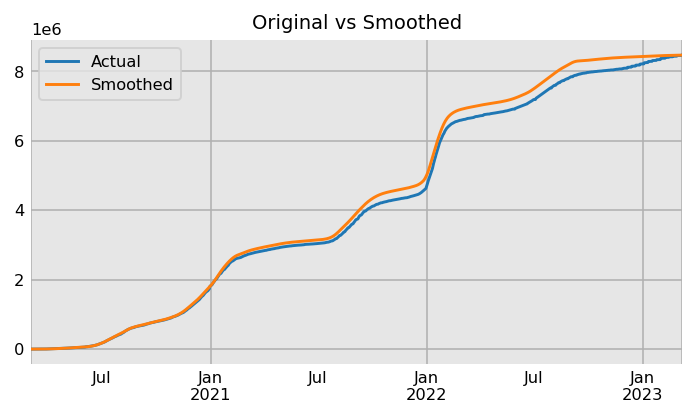

In [31]:
from solutions import smooth
smoothed = smooth(texasc, 20)
texasc.plot(label='Actual')
smoothed.plot(title='Original vs Smoothed', label='Smoothed').legend();

Here, we plot actual vs smoothed cases in California.

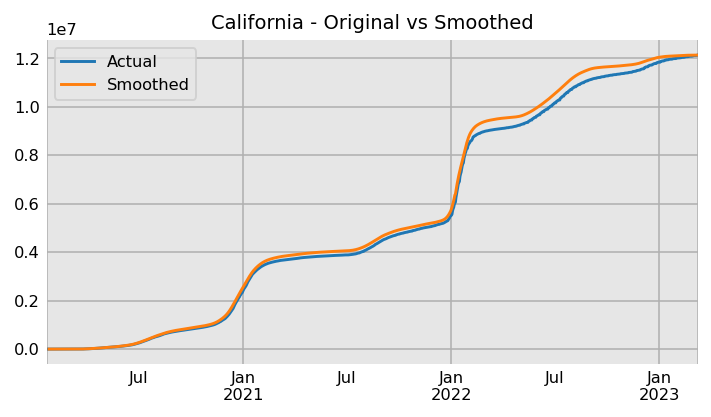

In [32]:
s = usa_cases['California']
smoothed = smooth(s, 20)
s.plot(label='Actual')
smoothed.plot(title='California - Original vs Smoothed', label='Smoothed').legend();